In [1]:
from collections.abc import Sequence
import json
from pathlib import Path
import re
from typing import Any

import h5py
import matplotlib.pyplot as plt
import nrrd
import numpy as np
from scipy.spatial.distance import euclidean
import vedo

from histalign.backend.models import AlignmentSettings, Orientation
from histalign.backend.registration import Registrator
from histalign.backend.registration.alignment import build_aligned_array
from histalign.backend.workspace import VolumeSlicer

vedo.settings.default_backend = "vtk"

In [2]:
PathType = str | Path

ALIGNMENT_FILE_NAME_PATTERN = re.compile(r"[0-9a-f]{32}\.json")
_SUPPORTED_TYPES = [".h5", ".hdf5", ".nrrd", ".json"]


def imshow(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis(False)
    plt.show()


def show(objects: object | Sequence[object]) -> None:
    try:
        objects = [] + objects
    except TypeError:
        objects = [objects]

    vedo.show(
        objects,
        interactive=False,
    ).interactive().close()


def load_file(path: PathType) -> Any:
    path = Path(path)
    if (suffix := path.suffix) not in _SUPPORTED_TYPES:
        raise ValueError(
            f"File extension not supported. Received: {suffix}. Allowed: {' '.join(_SUPPORTED_TYPES)}"
        )

    if suffix == ".json":
        data = json.load(path.open())
    elif suffix == ".nrrd":
        data = nrrd.read(path)[0]
    elif suffix in [".h5", ".hdf5"]:
        with h5py.File(path) as handle:
            data = handle[list(handle.keys())[0]][:]

    return data

In [3]:
atlas_path = "/home/ediun/.local/share/histalign/atlases/average_template_100.nrrd"
atlas_array = load_file(atlas_path)
atlas_volume = vedo.Volume(atlas_array)

In [4]:
alignment_array = np.zeros_like(atlas_array)
alignment_volume = vedo.Volume(alignment_array)

## Building an alignment volume

To build the array, the following steps are taken:
1. List all the alignment paths (settings file ending in .json)
2. For each alignment path, load the settings.
3. For each settings, load the image.
4. For each image, generate a 3D set of points given the alignment settings.
5. For each set of points, insert the image data.
6. For each set of points, interpolate the data into the final volume (go from mesh to grid).

### 1. List all the alignment paths

In [5]:
alignment_directory = Path(
    "/home/ediun/histalign-projects/microns_100_coronal_2d_artificial/1a862cb4e4"
)
alignment_paths = []
for child_path in alignment_directory.iterdir():
    if (
        child_path.is_dir()
        or re.fullmatch(ALIGNMENT_FILE_NAME_PATTERN, child_path.name) is None
    ):
        continue

    alignment_paths.append(child_path)

### 2. Load the settings

In [6]:
alignment_settings = [AlignmentSettings(**load_file(path)) for path in alignment_paths]

### 3. Load the images

In [7]:
images = [load_file(settings.histology_path) for settings in alignment_settings]

### 4A. Find the origin of the images

In [8]:
centre = (np.array(atlas_array.shape) - 1) / 2

origins = []
for settings in alignment_settings:
    if settings.volume_settings.orientation == Orientation.CORONAL:
        origin = centre + [settings.volume_settings.offset, 0, 0]
    elif settings.volume_settings.orientation == Orientation.HORIZONTAL:
        origin = centre + [0, settings.volume_settings.offset, 0]
    elif settings.volume_settings.orientation == Orientation.SAGITTAL:
        origin = centre + [0, 0, settings.volume_settings.offset]
    else:
        raise Exception("ASSERT NOT REACHED")

    origins.append(origin)

### 4B. Find the normals of the images

In [9]:
normals = []
for settings in alignment_settings:
    if settings.volume_settings.orientation == Orientation.CORONAL:
        normal = [1, 0, 0]
    elif settings.volume_settings.orientation == Orientation.HORIZONTAL:
        normal = [0, 1, 0]
    elif settings.volume_settings.orientation == Orientation.SAGITTAL:
        normal = [0, 0, 1]
    else:
        raise Exception("ASSERT NOT REACHED")

    normals.append(normal)

### 4C. Generate planes for the images

Each of the plane has an attribute called `points`.
This attribute contains 4 sets of coordinates. Using the right-hand rule, the first set is for the top-right point (smallest Y, largest Z), the second set is for the bottom-right (smallest y, smallest Z), the third set is for the top-left (largest Y, largest Z), and the fourth set is for the bottom-left (largest Y, smallest Z).

To visualise the positions, the following code can help:
```python
plane = planes[0]

cam = dict(
    position=(-250, 500, 250),
    focal_point=(50, 50, 50),
    viewup=(0, 0, 1),
)

vedo.show(
    [
        plane,
        vedo.Point(plane.points[0], r=10, c="red"),
        vedo.Point(plane.points[1], r=10, c="cyan"),
        vedo.Point(plane.points[2], r=10, c="blue"),
        vedo.Point(plane.points[3], r=10, c="black"),
    ],
    axes=3,
    camera=cam,
    interactive=False,
).interactive().close();
```

In [10]:
planes = []
for settings, origin, normal in zip(alignment_settings, origins, normals):
    plane = vedo.Plane(
        pos=origin, normal=normal, s=(1.5 * max(settings.volume_settings.shape),) * 2
    )

    planes.append(plane)

### 4D. Generate 3D points for each pixel of the images

In [11]:
point_clouds = []
for plane in planes:
    # Extract 3 corners of the plane. p1 is the closest to (0, 0, 0)
    p0, p1, _, p3 = plane.points

    # Compute the shape of the plane from two perpendicular edges. This is a fence/post
    # problem where fences are  the Euclidean distances and  pixels (i.e., shape) are
    # the posts. Hence, need to add one to each.
    shape = list(map(round, (euclidean(p1, p0) + 1, euclidean(p1, p3) + 1)))

    # Compute the normals of those two edges and normalise them to be unit length
    normal1 = (plane.points[0] - plane.points[1]) / euclidean(p1, p0)
    normal2 = (plane.points[3] - plane.points[1]) / euclidean(p1, p3)

    # Generate a grid of coordinates from (0, 0, 0) the same size at the plane
    # and only technically 2D.
    xs, ys = np.meshgrid(
        np.linspace(0, shape[0], shape[0]), np.linspace(0, shape[1], shape[1])
    )
    points = np.vstack([xs.ravel(), ys.ravel()])

    # Convert the grid to 3D based on the plane orthogonal normals
    points = np.dot(np.vstack((normal1, normal2)).T, points).T

    # Translate grid origin to the plane's bottom-right
    points = p1 + points

    points = vedo.Points(points)
    point_clouds.append(points)

### 5. Insert image data into point clouds

In [12]:
registrator = Registrator()
for points, image, settings, origin in zip(
    point_clouds, images, alignment_settings, origins
):
    registered_image = registrator.get_forwarded_image(image, settings, origin.tolist())
    # TODO: Very ugly. Why need to shift by 1?
    # registered_image = registered_image[1:]
    # registered_image = np.pad(registered_image, [[0, 1], [0, 0]])

    points.pointdata["ImageScalars"] = registered_image.flatten()

### 6. Interpolate the point clouds into the final volume

In [13]:
interpolation_array = np.zeros_like(alignment_array)
for points in point_clouds:
    tmp_array = alignment_volume.interpolate_data_from(
        points, radius=1, kernel="shepard"
    ).tonumpy()
    tmp_array = np.round(tmp_array).astype(np.uint16)

    interpolation_array[:] = np.maximum(interpolation_array, tmp_array)

alignment_volume = vedo.Volume(interpolation_array)

### 7. Checking the work

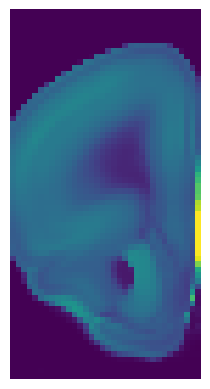

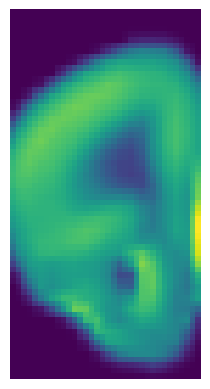

In [29]:
atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(alignment_settings[0].volume_settings)

alignment_slicer = VolumeSlicer(volume=alignment_volume)
actual_image = alignment_slicer.slice(alignment_settings[0].volume_settings)

# roi = (slice(None), slice(None))
roi = (slice(66, 132), slice(66, 100))
# roi = (slice(75, 85), slice(90, 100))
# roi = (slice(75, 95), slice(90, 110))

imshow(target_image[roi])
imshow(actual_image[roi])

### 8. Comparing with current implementation

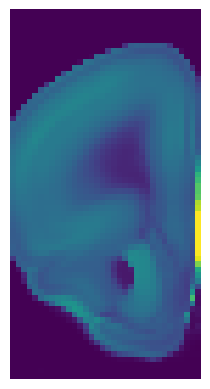

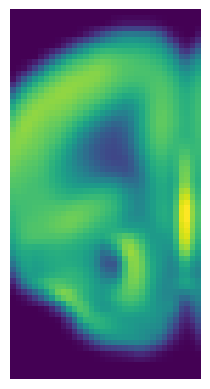

In [30]:
build_aligned_array(alignment_directory, "", "", "")
current_alignment_array = load_file(
    "/home/ediun/histalign-projects/microns_100_coronal_2d_artificial/1a862cb4e4/volumes/aligned/1a862cb4e4.h5"
)
current_alignment_volume = vedo.Volume(current_alignment_array)

atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(alignment_settings[0].volume_settings)

current_alignment_slicer = VolumeSlicer(volume=current_alignment_volume)
actual_image = current_alignment_slicer.slice(alignment_settings[0].volume_settings)

imshow(target_image[roi])
imshow(actual_image[roi])

### Conclusion

There is a sizable difference between the implementations. This needs to be fixed.